# Row and preprocessed data analysis

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import os
sys.path.append(os.path.abspath('..')) 
from src.config import setup_logging
logger = setup_logging("DEBUG")

from src.data.data_utils import num_to_name, num_to_data_path, load_data

## Row data

In [2]:
num_datasets = 6
data = []

X_datasets = []
y_datasets = []

for i in range(num_datasets):
    X_i, y_i = load_data(num_to_data_path(i+1))
    X_datasets.append(X_i)
    y_datasets.append(y_i)

    data.append([f"{num_to_name(i+1)}", X_i.shape, y_i.shape])

df = pd.DataFrame(data, columns=["Dataset", "X shape", "y shape"])
print(df.to_string(index=False))

INFO - Loading data from ../data/idash.txt
INFO - Loaded dataset with 1579 samples and 18 features
INFO - Loading data from ../data/edinburgh.txt
INFO - Loaded dataset with 1253 samples and 9 features
INFO - Loading data from ../data/lbw.txt
INFO - Loaded dataset with 189 samples and 9 features
INFO - Loading data from ../data/nhanes3.txt
INFO - Loaded dataset with 15649 samples and 15 features
INFO - Loading data from ../data/pcs.txt
INFO - Loaded dataset with 379 samples and 9 features
INFO - Loading data from ../data/uis.txt
INFO - Loaded dataset with 575 samples and 8 features


  Dataset     X shape  y shape
    idash  (1579, 18)  (1579,)
edinburgh   (1253, 9)  (1253,)
      lbw    (189, 9)   (189,)
  nhanes3 (15649, 15) (15649,)
      pcs    (379, 9)   (379,)
      uis    (575, 8)   (575,)


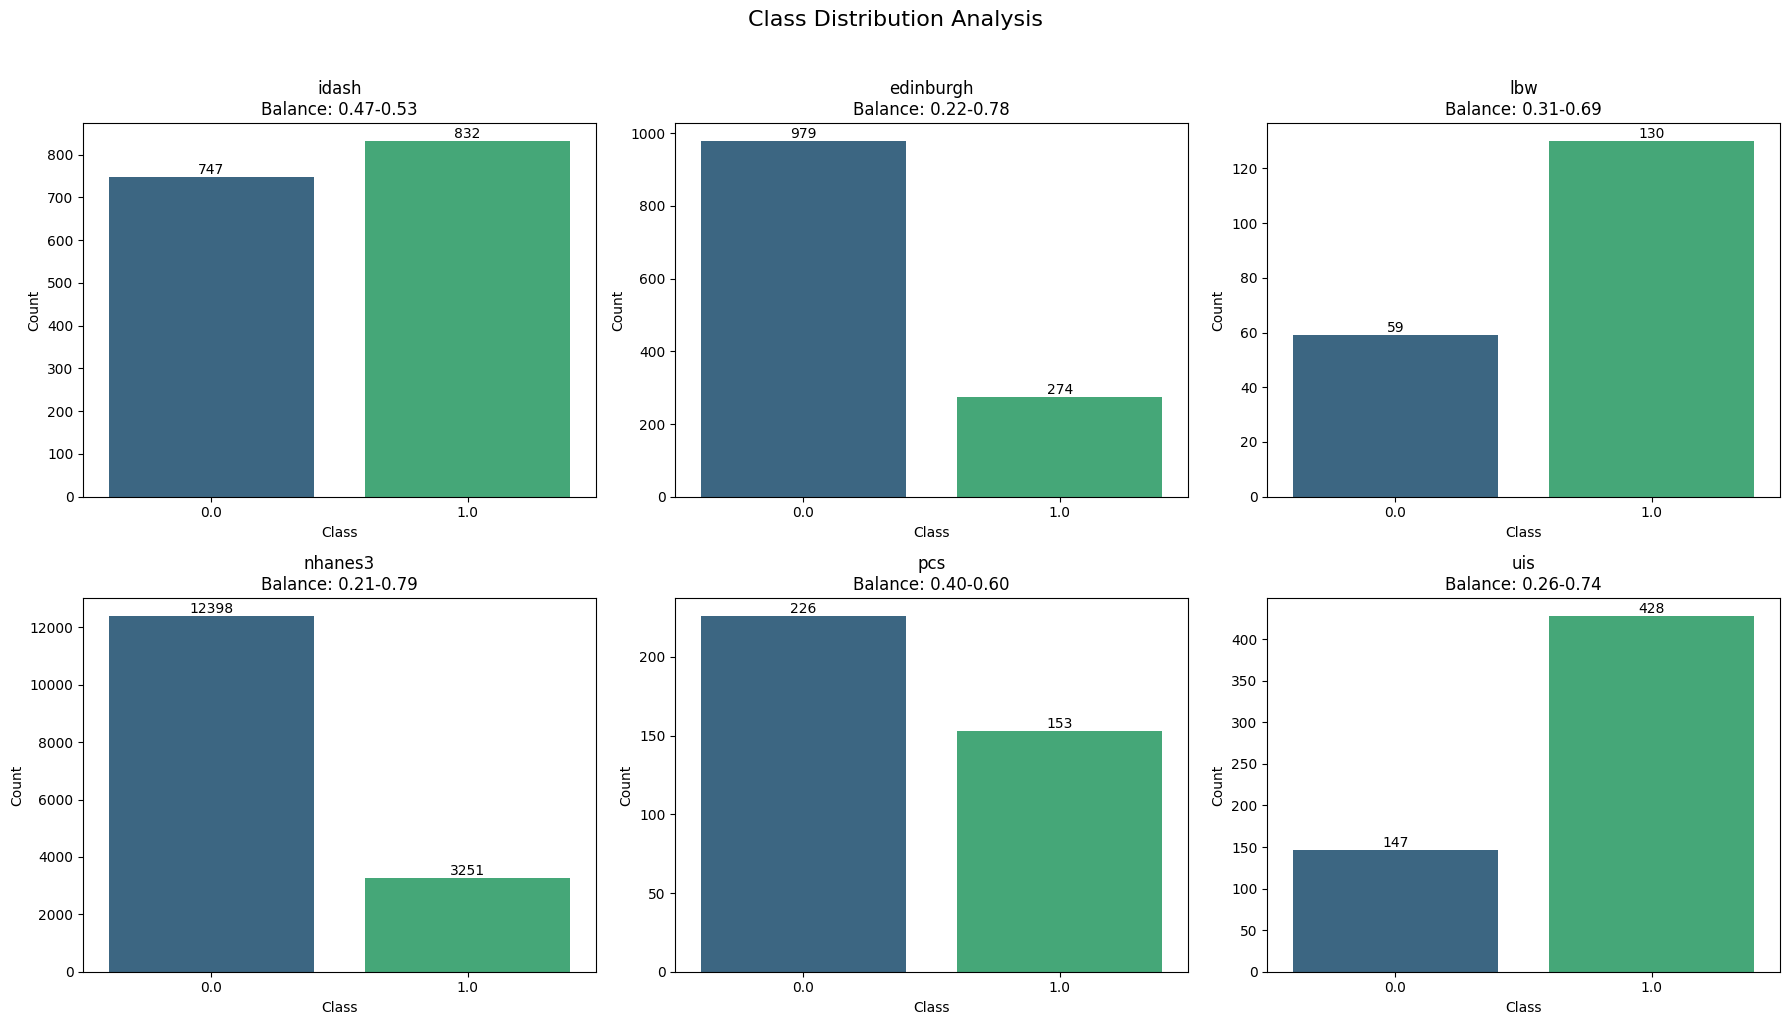

In [3]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i in range(num_datasets):
    y_i = y_datasets[i]
    class_counts = pd.Series(y_i).value_counts().sort_index()
    class_ratio = class_counts / len(y_i)
    
    sns.barplot(x=class_counts.index, 
                y=class_counts.values, 
                ax=axes[i],
                hue=class_counts.index,
                palette="viridis",
                legend=False)
    
    axes[i].set_title(f"{num_to_name(i+1)}\n"
                     f"Balance: {class_ratio.min():.2f}-{class_ratio.max():.2f}")
    axes[i].set_xlabel("Class")
    axes[i].set_ylabel("Count")
    
    for p in axes[i].patches:
        axes[i].annotate(f"{int(p.get_height())}", 
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', 
                        xytext=(0, 5), 
                        textcoords='offset points')

plt.suptitle("Class Distribution Analysis", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

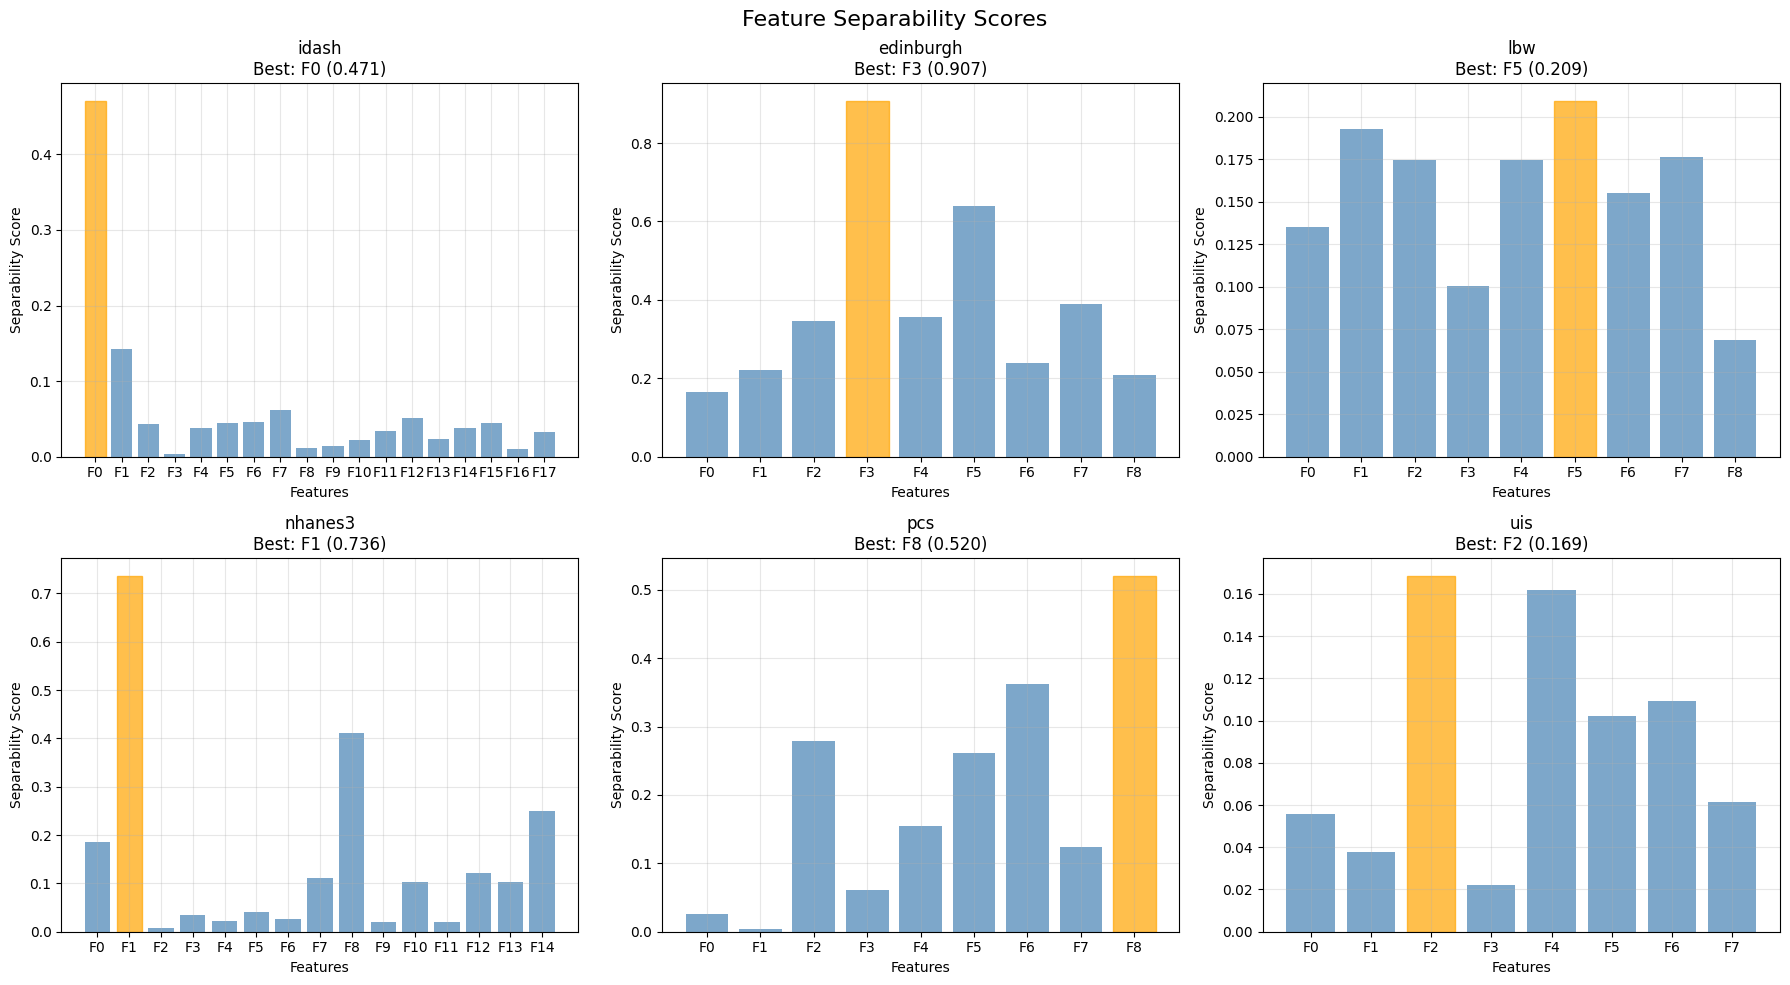

In [4]:
def calculate_separability_score(X, y):
    separability_scores = []
    
    for j in range(X.shape[1]):
        class_means = [X[y == c, j].mean() for c in np.unique(y)]
        class_stds = [X[y == c, j].std() for c in np.unique(y)]
        
        # Avoid division by zero
        mean_std = np.mean(class_stds)
        if mean_std > 0:
            separability = np.std(class_means) / mean_std
        else:
            separability = 0
        separability_scores.append(separability)
    
    return np.array(separability_scores)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

separability_results = {}

for i, (X_i, y_i) in enumerate(zip(X_datasets, y_datasets)):
    separability = calculate_separability_score(X_i, y_i)
    separability_results[i] = separability
    
    feature_names = [f"F{j}" for j in range(len(separability))]
    best_feature = np.argmax(separability)

    # Bar plot
    bars = axes[i].bar(feature_names, separability, alpha=0.7, color='steelblue')
    
    # Highlight best feature
    bars[best_feature].set_color('orange')
    
    axes[i].set_title(f"{num_to_name(i+1)}\nBest: F{best_feature} ({separability[best_feature]:.3f})")
    axes[i].set_xlabel("Features")
    axes[i].set_ylabel("Separability Score")
    axes[i].grid(True, alpha=0.3)

plt.suptitle("Feature Separability Scores", fontsize=16)
plt.tight_layout()
plt.show()


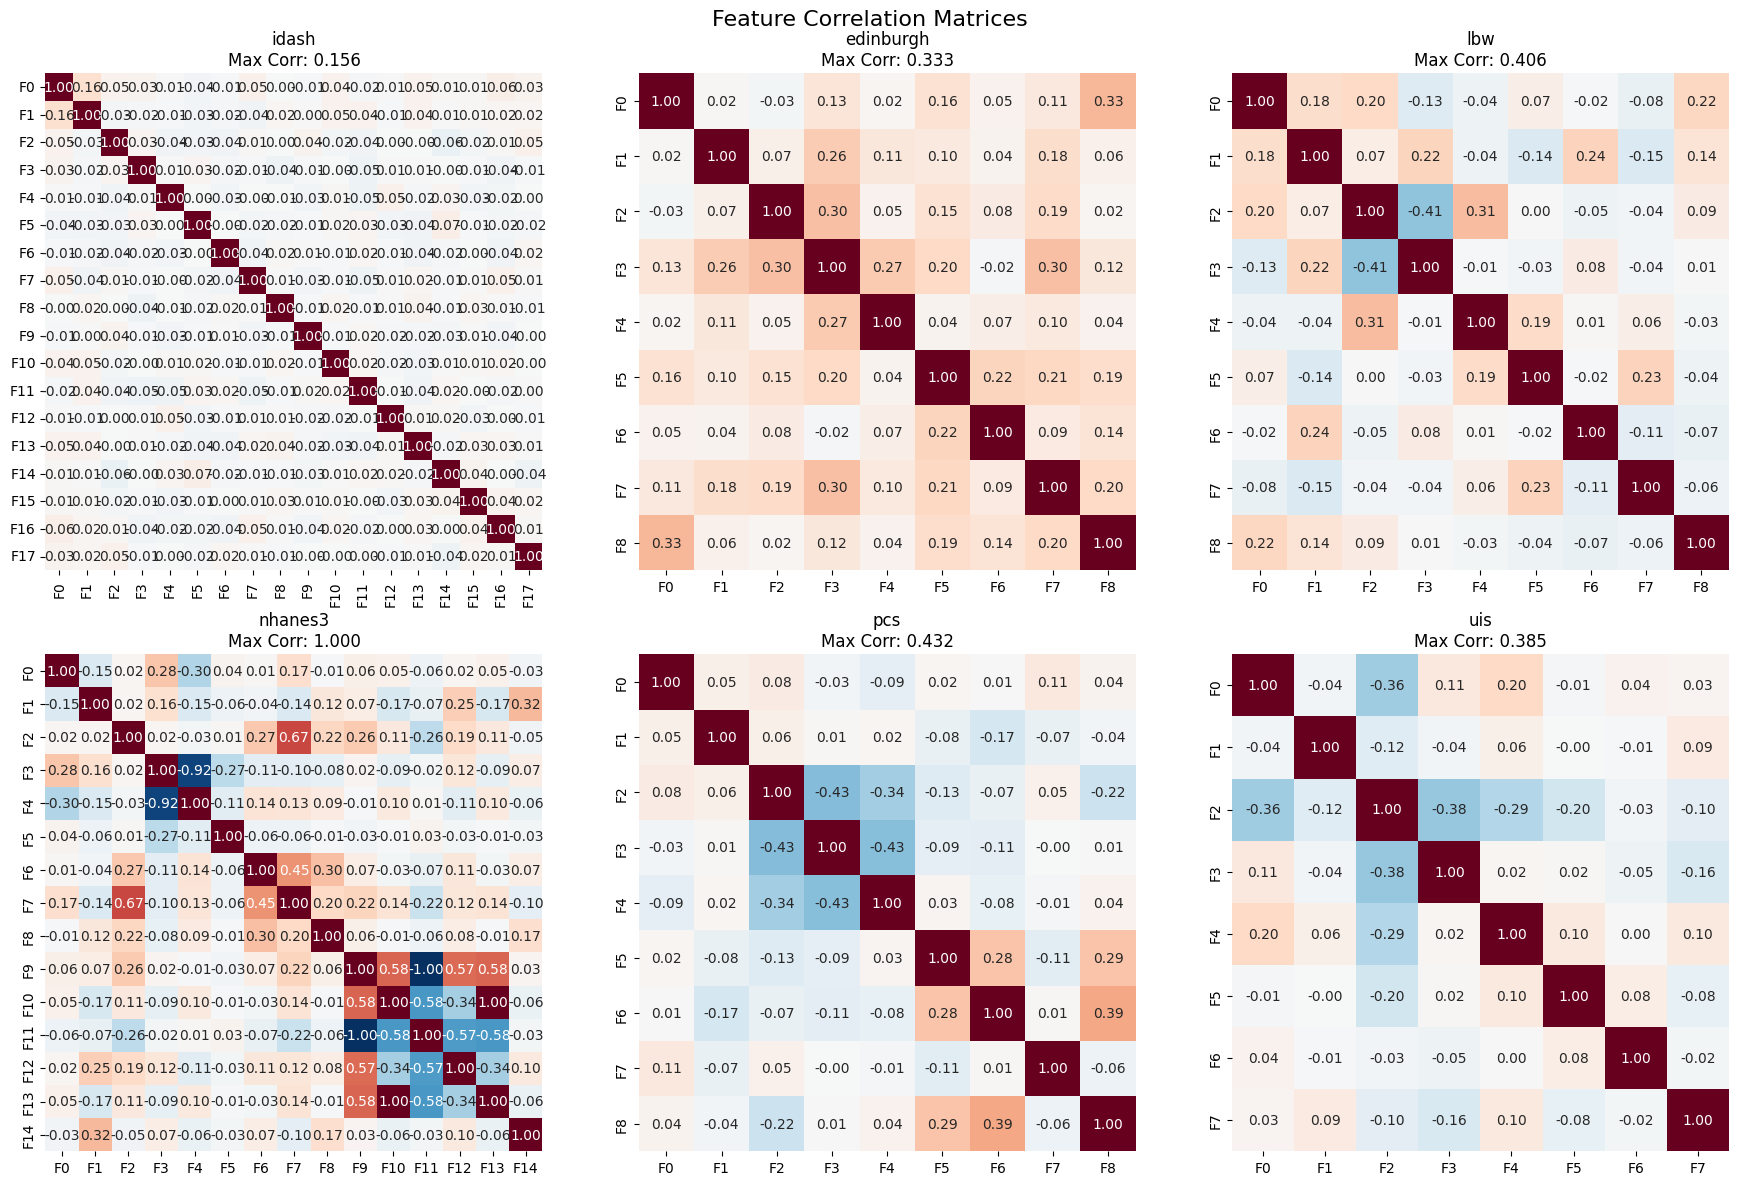

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

correlation_results = {}
for i, X_i in enumerate(X_datasets):
    corr_matrix = np.corrcoef(X_i.T)
    correlation_results[i] = corr_matrix
    
    upper_triangle = corr_matrix[np.triu_indices_from(corr_matrix, k=1)]
    max_corr = np.abs(upper_triangle).max()
    
    feature_names = [f"F{j}" for j in range(X_i.shape[1])]
    sns.heatmap(corr_matrix, xticklabels=feature_names, yticklabels=feature_names,
               annot=True, fmt=".2f", cmap="RdBu_r", center=0, 
               square=True, ax=axes[i], cbar=False)
    axes[i].set_title(f"{num_to_name(i+1)}\nMax Corr: {max_corr:.3f}")

plt.suptitle("Feature Correlation Matrices", fontsize=16)
plt.tight_layout()
plt.show()

## Preprocessing

In [6]:
from src.data.preprocessing import bin_to_pm1, add_bias, init_wv, pad_to_pow2_cols, pad_to_pow2_rows
from src.data.data_utils import train_test_split, stack_and_scale
from src.data.scalers import StandardScaler, MaxAbsScaler, MinMaxScaler

In [7]:
# Parameters
dataset_num = 4
scaler = MaxAbsScaler()
beta_init_method = "zero"  # mean, zero, random

In [8]:
X = X_datasets[dataset_num - 1]
y_bin = y_datasets[dataset_num - 1]

In [9]:
# iDASH
y_pm1 = bin_to_pm1(y_bin)

X_ = add_bias(X)
Z = y_pm1[:, np.newaxis] * X_

X_train, X_test, y_bin_train, y_bin_test = train_test_split(Z, y_bin, test_size=0.2)
Z_train, Z_test = stack_and_scale(scaler, X_train, X_test)

# Z_train = pad_to_pow2_cols(Z_train)
# Z_train = pad_to_pow2_rows(Z_train)
# Z_test = pad_to_pow2_cols(Z_train)

w, v = init_wv(Z_train, method=beta_init_method)

INFO - Adding bias term
DEBUG - Added bias term: (15649, 15) -> (15649, 16)
INFO - Splitting data into train/test sets
DEBUG - Train size: 12519, Test size: 3130
INFO - Stacking and scaling data
DEBUG - Scaled rang: [-1.0, 1.0]
INFO - Initializing weights for 16 features as: 'zero'
DEBUG - Weight stats - Min: 0.0000, Max: 0.0000, Mean: 0.0000


In [10]:
# X_ = add_bias(X)

# X_train, X_test, y_bin_train, y_bin_test = train_test_split(X_, y_bin, test_size=0.2)

# Z_train = scaler.fit_transform(X_train)
# Z_test = scaler.transform(X_test)

# Z_train = bin_to_pm1(y_bin_train)[:, np.newaxis] * Z_train

# # Z_train = pad_to_pow2_cols(Z_train)
# # Z_train = pad_to_pow2_rows(Z_train)
# # Z_test = pad_to_pow2_cols(Z_train)

# w, v = init_wv(Z_train, method=beta_init_method)

In [11]:
def analyze_transformations(X, Z_train, Z_test):
    stats = {
        'Original': {
            'Mean': X.mean(),
            'Std': X.std(),
            'Min': X.min(),
            'Max': X.max()
        },
        'Z_train': {
            'Mean': Z_train.mean(),
            'Std': Z_train.std(),
            'Min': Z_train.min(),
            'Max': Z_train.max()
        },
        'Z_test': {
            'Mean': Z_test.mean(),
            'Std': Z_test.std(),
            'Min': Z_test.min(),
            'Max': Z_test.max()
        }
    }
    
    df_stats = pd.DataFrame(stats).T
    print(df_stats.round(2))

    print(f"\nX original: {X.shape}")
    print(f"y binaire: {y_bin.shape}")
    print(f"Z_train: {Z_train.shape}, Z_test: {Z_test.shape}")
    print(f"w: {w.shape}, v: {v.shape}")

analyze_transformations(X, Z_train, Z_test)

            Mean      Std  Min       Max
Original  746.34  4331.38  0.0  139744.9
Z_train    -0.24     0.55 -1.0       1.0
Z_test     -0.24     0.55 -1.0       1.0

X original: (15649, 15)
y binaire: (15649,)
Z_train: (12519, 16), Z_test: (3130, 16)
w: (16,), v: (16,)


## Scaler

In [12]:
def plot_feature_distribution(dataset_idx=0, feature_idx=0):
    standard = StandardScaler()
    maxAbs = MaxAbsScaler()
    minmax = MinMaxScaler()

    X_orig = X_datasets[dataset_idx]
    X_std = standard.fit_transform(X_orig)
    X_maxabs = maxAbs.fit_transform(X_orig)
    X_minmax = minmax.fit_transform(X_orig)
    
    plt.figure(figsize=(12, 6))
    plt.hist(X_orig[:, feature_idx], bins=30, alpha=0.4, label='Original')
    plt.hist(X_std[:, feature_idx], bins=30, alpha=0.5, label='StandardScaler')
    plt.hist(X_maxabs[:, feature_idx], bins=30, alpha=0.8, label='MaxAbsScaler')
    plt.hist(X_minmax[:, feature_idx], bins=30, alpha=0.7, label='MinMaxScaler')
    
    dataset_name = num_to_name(dataset_idx+1)
    plt.title(f"Dataset {dataset_name} - Feature {feature_idx}\n"
             f"Original shape: {X_orig.shape}, Feature range: "
             f"[{X_orig[:, feature_idx].min():.2f}, {X_orig[:, feature_idx].max():.2f}]")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

DEBUG - Scaled rang: [-2.0011450900368004, 6.481366695591031]
DEBUG - Scaled rang: [0.0, 1.0]
DEBUG - Scaled rang: [0.0, 1.0]


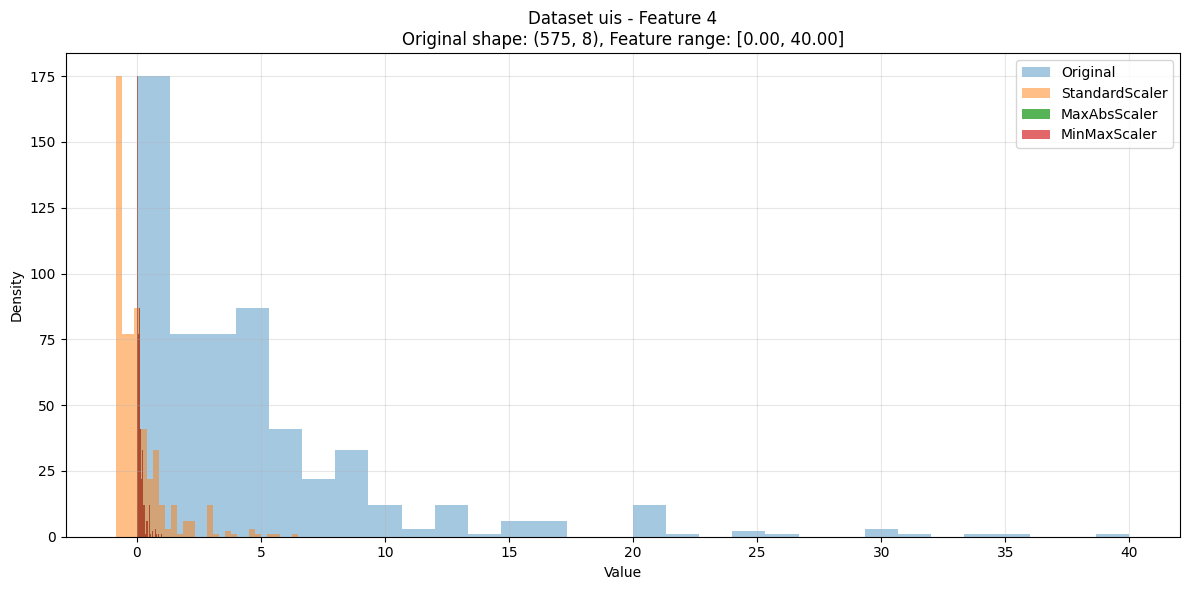

In [13]:
plot_feature_distribution(dataset_idx=5, feature_idx=4)

### Padding + biais

In [14]:
from matplotlib.colors import LinearSegmentedColormap

def plot_padding_matrix(X_before, X_after, dataset_name=""):
    cmap = LinearSegmentedColormap.from_list('padding_cmap', ['white', 'lightgray', 'red'])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    
    im1 = ax1.imshow(X_before, cmap='viridis', aspect='auto')
    ax1.set_title(f"Before Padding\nShape: {X_before.shape}")
    fig.colorbar(im1, ax=ax1, shrink=0.6)
    
    mask = (X_after == 0)
    im2 = ax2.imshow(X_after, cmap='viridis', aspect='auto')
    
    zeros_layer = np.ma.masked_where(~mask, mask)
    ax2.imshow(zeros_layer, cmap=cmap, alpha=0.7, aspect='auto')
    
    ax2.set_title(f"After Padding\nShape: {X_after.shape}")
    fig.colorbar(im2, ax=ax2, shrink=0.6)
    
    # Annotations
    for ax in (ax1, ax2):
        ax.set_xlabel("Features")
        ax.set_ylabel("Samples")
    
    plt.suptitle(f"Padding Visualization - {dataset_name}\n",
                y=1.05, fontsize=14)
    plt.tight_layout()
    plt.show()

DEBUG - Scaled rang: [0.0, 1.0]
INFO - Adding bias term
DEBUG - Added bias term: (575, 8) -> (575, 9)
INFO - Padding columns: 9 -> 16 (next power of 2)
INFO - Padding rows: 575 -> 1024 (next power of 2)


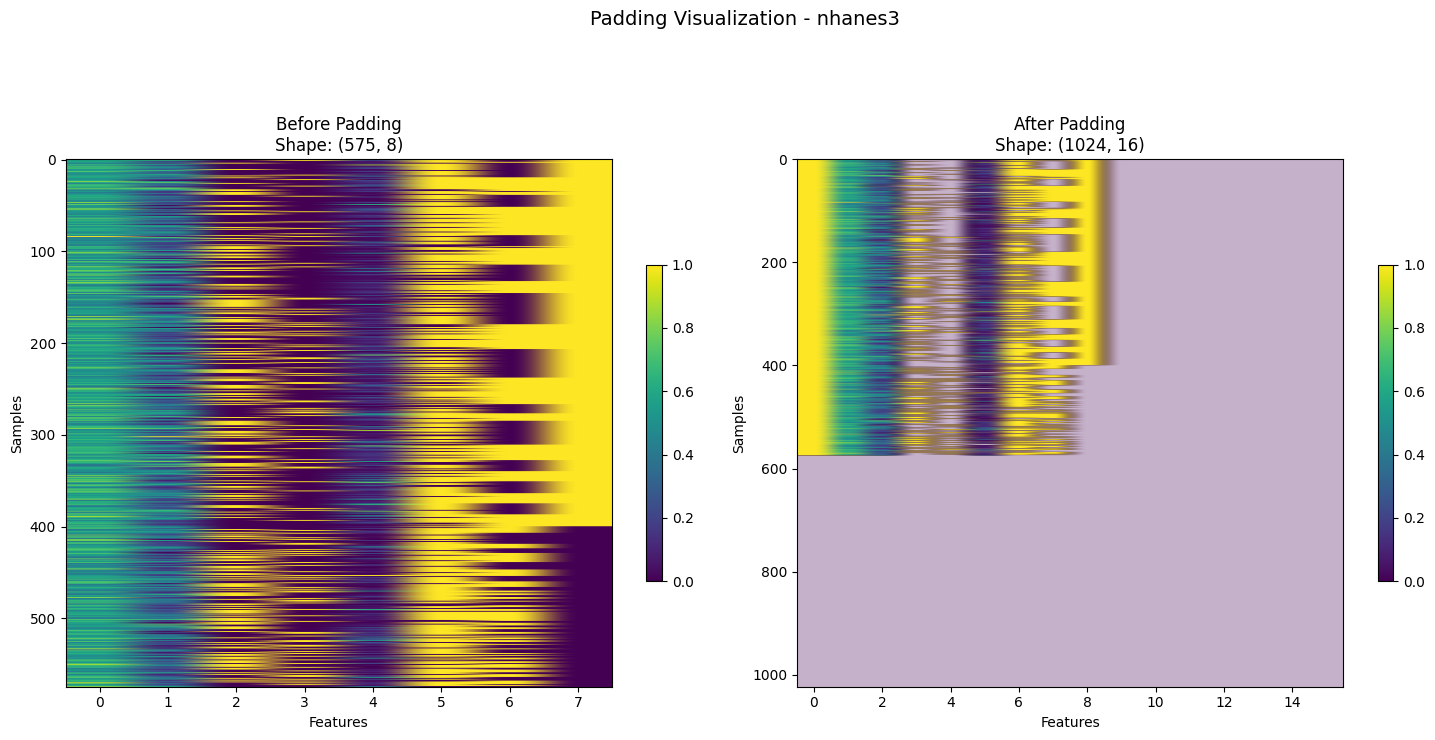

In [15]:
X_before = X_datasets[num_datasets - 1]
X_before = scaler.fit_transform(X_before)
X_after = pad_to_pow2_rows(pad_to_pow2_cols(add_bias(X_before)))

plot_padding_matrix(X_before, X_after, f"{num_to_name(dataset_num)}")